## Libraries

In [1]:
%pip install pynrrd numpy torch torchvision monai tensorflow wandb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import monai
import os
import csv
import numpy as np
import nrrd
import torch
import PIL
import IPython.display
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
def pad(array, target_shape, value=-1000):
    shape = array.shape
    if len(shape) != len(target_shape):
        raise ValueError("Target shape does not have same amount of dimensions as input array.")
    for dim in range(len(target_shape)):
        if target_shape[dim] < shape[dim]:
            raise ValueError("Atleast one target dimension is smaller than the current dimension.")

    result = np.ones(target_shape)*value
    indices = list()
    for dim in range(len(target_shape)):
        pad_range = (target_shape[dim]-shape[dim])//2
        indices.append([pad_range, pad_range+shape[dim]])
    selection = tuple([slice(ind[0], ind[1]) for ind in indices])
    result[selection]=array
    return result, indices

def unpad(array, indices):
    if len(indices) != len(array.shape):
        raise ValueError("Number of dimensions differs between array and indices.")

    selection = tuple([slice(ind[0], ind[1]) for ind in indices])
    return array[selection]

In [5]:
def build_dict_ASOCA(data_path, mode="train"):
    # test if mode is correct
    if mode not in ["train", "validation", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'validation', 'test']. Current mode is {mode}.")

    # create empty dictionary
    dicts = list()

    for clazz in ["Diseased", "Normal"]:
        if mode == "train":
            for index in range(1,17):
                image_path = os.path.join(data_path, clazz, "CTCA", f"{clazz}_{index}.nrrd")
                mask_path = os.path.join(data_path, clazz, "Annotations", f"{clazz}_{index}.nrrd")
                dicts.append({"img": image_path, "mask": mask_path})
        if mode == "validation":
            for index in range(17,21):
                image_path = os.path.join(data_path, clazz, "CTCA", f"{clazz}_{index}.nrrd")
                mask_path = os.path.join(data_path, clazz, "Annotations", f"{clazz}_{index}.nrrd")
                dicts.append({"img": image_path, "mask": mask_path})
        if mode == "test":
            if clazz == "Diseased":
                for index in range(10,20):
                    image_path = os.path.join(data_path, clazz, f"Testset_Disease", f"{index}.nrrd")
                    dicts.append({"img": image_path})
            else:
                for index in range(10):
                    image_path = os.path.join(data_path, clazz, f"Testset_{clazz}", f"{index}.nrrd")
                    dicts.append({"img": image_path})
    return dicts

class LoadASOCAData(monai.transforms.Transform):
    
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        dicts = dict()
        image = nrrd.read(sample["img"])[0]
        image, indices = pad(image, (512,512,352))
        dicts["img"] = torch.tensor(image).unsqueeze(0).float()
        dicts["indices"] = indices
        dicts["sample"] = sample # For verifying e.g. padding
        if "mask" in sample.keys():
            mask = nrrd.read(sample["mask"])[0]
            mask, indices = pad(mask, (512,512,352), value=0)
            dicts["mask"] = torch.tensor(mask).unsqueeze(0).long()
        return dicts

In [6]:
# adjust cache_rate based on how much memory you have. test_dataset is only used for visualization / at end, so dont need to cache it
# Look at prob

train_transform = monai.transforms.Compose([
    LoadASOCAData(),
    monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
    monai.transforms.RandFlipd(keys=['img', 'mask'], prob=1, spatial_axis=1),
    monai.transforms.RandRotated(keys=['img', 'mask'], range_x=np.pi/4, prob=1, mode=['bilinear', 'nearest'])
])

val_transform = monai.transforms.Compose([
    LoadASOCAData(),
    monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
])

train_dataset = monai.data.CacheDataset(build_dict_ASOCA("ASOCA", mode="train"), transform=train_transform)
validation_dataset = monai.data.CacheDataset(build_dict_ASOCA("ASOCA", mode="validation"), transform=val_transform)
#test_dataset = monai.data.CacheDataset(build_dict_ASOCA("ASOCA", mode="test"), transform=LoadASOCAData(), cache_rate=0)

Loading dataset: 100%|██████████| 8/8 [00:32<00:00,  4.03s/it]


In [ ]:
# !!! Will not work anymore since transforms are applied !!!
# verifying padding and unpadding
image = nrrd.read("ASOCA/Normal/CTCA/Normal_3.nrrd")[0]
print(train_dataset[0]["sample"]) # should be same as above
image2 = unpad(train_dataset[0]["img"].numpy().squeeze().astype(np.int32), train_dataset[0]["indices"])
(image == image2).all()

In [8]:
color_actual = [0, 0.5, 0]
color_predicted = [0, 0, 0.5]

def RGB_mask(mask, color):
    result = np.zeros((*mask.shape,3))
    for i in range(3):
        result[...,i]=color[i]*mask
    return result


def RGB_image(image):
    result = image-image.min() # [a,b] -> [0, b-a]
    result = result/result.max() # [0, b-a] -> [0,1] -> [0,255]
    return np.repeat(np.reshape(result[:,:,:], [image.shape[0],image.shape[1],image.shape[2],1]),3,axis=3)

def visualize_3d_gif(indices, image=None, actual_mask=None, predicted_mask=None, name_gif="array.gif"):
    if image is not None:
        image = image.numpy().squeeze()
        image = unpad(image, indices)
        rgb_image = RGB_image(image)
        result = rgb_image
    for i in range(2):
        mask = [actual_mask, predicted_mask][i]
        if mask is not None:
            mask = mask.numpy().squeeze()
            mask = unpad(mask, indices)
            rgb_mask = RGB_mask(mask, [color_actual, color_predicted][i])
            if result is not None:
                result += rgb_mask
            else:
                result = rgb_mask

    result = result/np.max(result)*255
    result = result.astype(np.uint8)
    images = [PIL.Image.fromarray(result[:,:,index,:]) for index in range(image.shape[2])]
    images[0].save(name_gif, save_all=True, append_images=images[1:],loop=0)

def visualize_3d_masks(indices, actual_mask=None, predicted_mask=None):
    fig=plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    for i in range(2):
        mask = [actual_mask, predicted_mask][i]
        if mask is not None:
            mask = mask.numpy().squeeze()
            mask = unpad(mask, indices)
            pos = np.where(mask==1)
            ax.scatter(pos[0],pos[1],pos[2], color=[color_actual, color_predicted][i])

    # multiple figures at different angles?
    #ax.view_init(45, 0)
    plt.show()    

def visualize_histogram(indices, image, mask):
    image = image.numpy().squeeze()
    image = unpad(image, indices)
    mask = mask.numpy().squeeze()
    mask = unpad(mask, indices)
    fig, axs = plt.subplots(1, 2, tight_layout=True) 
    axs[0].hist(image[mask==0], bins=20)
    axs[0].set_title("Background class")
    axs[1].hist(image[mask==1], bins=20)
    axs[1].set_title("Vessel class")   
    plt.show()

In [ ]:
visualize_3d_gif(train_dataset[1]["indices"],image=train_dataset[1]["img"], actual_mask=train_dataset[1]["mask"])
display(IPython.display.Image(data=open("array.gif",'rb').read(), format='png'))
visualize_3d_masks(train_dataset[1]["indices"], actual_mask=train_dataset[1]["mask"])
visualize_histogram(train_dataset[1]["indices"], train_dataset[1]["img"],train_dataset[1]["mask"])

In [9]:
import wandb
wandb.login()

#train_loader = monai.data.DataLoader(train_dataset, batch_size=1, num_workers=1)
validation_loader = monai.data.DataLoader(validation_dataset, batch_size=1, num_workers=1)
device = torch.device("cuda")
model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: d-weistra (d-weistra-university-of-twente) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
run = wandb.init(
    project='ASOCAproject',
    name='test_1',
    config={
        'loss function': str(loss_function), 
        'lr': optimizer.param_groups[0]["lr"],
        'batch_size': train_loader.batch_size,
    }
)
# Do not hesitate to enrich this list of settings to be able to correctly keep track of your experiments!
# For example you should add information on your model...

run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

def wandb_masks(mask_output, mask_gt):
    """ Function that generates a mask dictionary in format that W&B requires """

    # Apply sigmoid to model ouput and round to nearest integer (0 or 1)
    sigmoid = torch.nn.Sigmoid()
    mask_output = sigmoid(mask_output)
    mask_output = torch.round(mask_output)

    # Transform masks to numpy arrays on CPU
    # Note: .squeeze() removes all dimensions with a size of 1 (here, it makes the tensors 2-dimensional)
    # Note: .detach() removes a tensor from the computational graph to prevent gradient computation for it
    mask_output = mask_output.squeeze().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()

    # Create mask dictionary with class label and insert masks
    class_labels = {1: 'arteries'}
    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks

def log_to_wandb(epoch, train_loss, val_loss, batch_data):
    """ Function that logs ongoing training variables to W&B """
    # This part is not yet working
    # def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    # Create list of images that have segmentation masks for model output and ground truth
    #log_imgs = [wandb.Image(img, masks=wandb_masks(mask_output, mask_gt)) for img, mask_output,
    #            mask_gt in zip(batch_data['img'], outputs, batch_data['mask'])]

    # Send epoch, losses and images to W&B
    #wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})

for epoch in tqdm(range(200)):
    # training
    model.train()
    epoch_loss=0
    step=0
    for batch in train_loader:  # Nested tqdm for training steps
        #print(step)
        step += 1
        optimizer.zero_grad()
        inputs = batch["img"].to(device)
        labels = batch["mask"].to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() 
    train_loss = epoch_loss / step
    
    # validation
    step = 0
    val_loss = 0
    with torch.no_grad():
        for batch in validation_loader:  # Nested tqdm for training steps
            #print(step)
            step += 1
            model.eval()
            inputs = batch["img"].to(device)
            labels = batch["mask"].to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss+= loss.item()
        val_loss = val_loss / step
    
    log_to_wandb(epoch, train_loss, val_loss, batch)
    print(f"Epoch {epoch+1}, Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")
    
    torch.save(model.state_dict(),os.path.join(f"Trained", f"trainedUNet_epoch{epoch}.pt"))
run.finish()

In [10]:
model.load_state_dict(torch.load(r'Trained/trainedUNet_epoch87.pt'))
#model.load_state_dict(torch.load(r'TrainedASOCA.pt'))

<All keys matched successfully>

In [22]:
def visual_evaluation(sample, model):
    """
    Allow the visual inspection of one sample by plotting the X-ray image, the ground truth (green)
    and the segmentation map produced by the network (red).
    
    Args:
        sample (Dict[str, torch.Tensor]): sample composed of an X-ray ('img') and a mask ('mask').
        model (torch.nn.Module): trained model to evaluate.
    """
    model.eval()
    discrete_transform = monai.transforms.AsDiscrete(logit_thresh=0.5, threshold_values=True)
    Softmax = torch.nn.Softmax()
    with torch.no_grad():
        output = discrete_transform(Softmax(model(sample['img'].to('cuda:1'))).cpu()).squeeze()
        output = np.squeeze(output[1, :, :, :])
        print(output.shape)
    
    fig=plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    indices = sample['indices']
    actual_mask = np.squeeze(sample['mask'])
    actual_mask = unpad(actual_mask, indices)
    pos = np.where(actual_mask==1)
    print(len(pos[0]))
    ax.scatter(pos[0],pos[1],pos[2], color=color_actual)
    
    #output = unpad(output, indices)
    pos2 = np.where(output == 1)
    print(len(pos2[0]))
    ax.scatter(pos2[0],pos2[1],pos2[2], color=color_predicted)
   
    plt.show()

/usr/local/lib/python3.10/dist-packages/torch/overrides.py:1636: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)


(512, 512, 352)
29538
4486


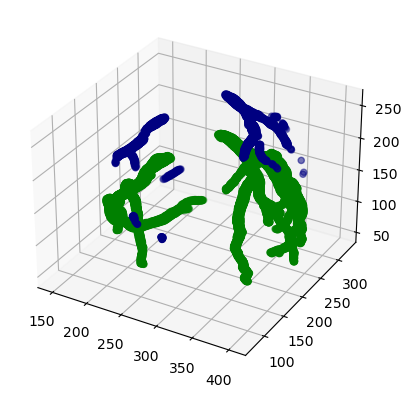

(512, 512, 352)
36414
3289


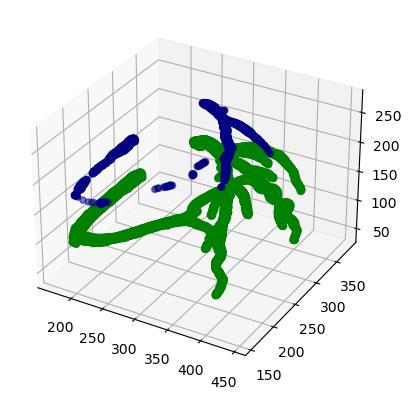

(512, 512, 352)
28168
5206


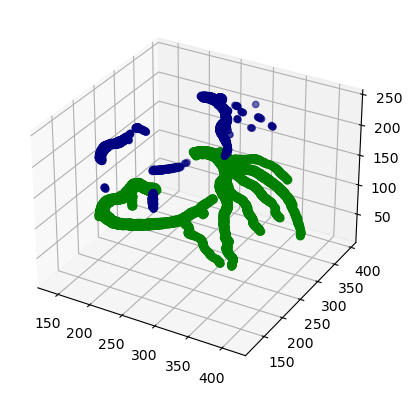

(512, 512, 352)
30631
5366


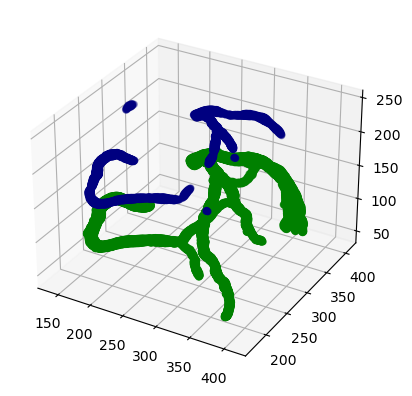

(512, 512, 352)
26347
6922


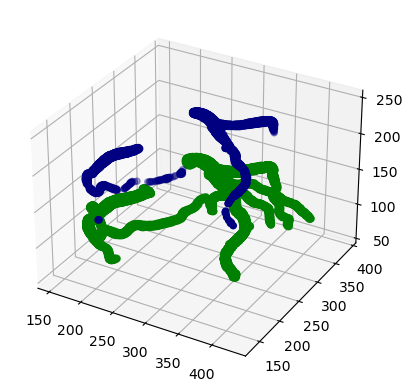

(512, 512, 352)
40902
15375


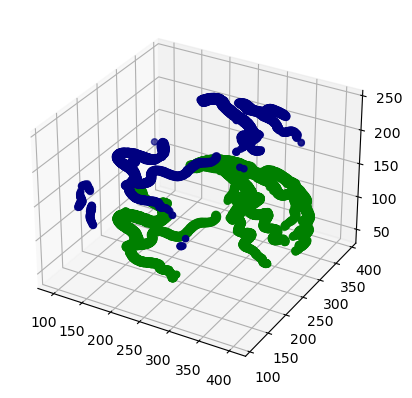

(512, 512, 352)
23926
4415


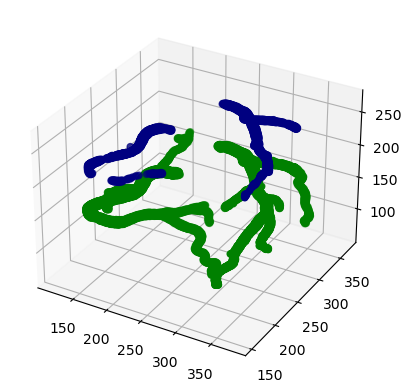

(512, 512, 352)
24746
7237


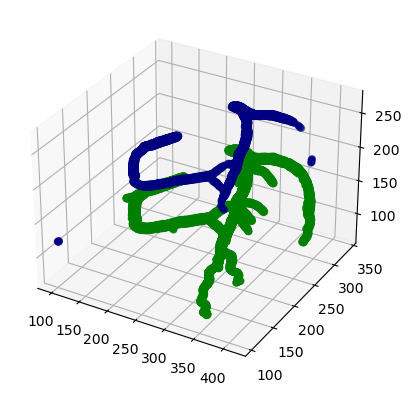

In [23]:
for sample in validation_loader:
    visual_evaluation(sample, model.to('cuda:1'))

In [13]:
!nvidia-smi

Tue Mar 25 10:57:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:3B:00.0 Off |                    0 |
| N/A   45C    P0             26W /   70W |   14623MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----